In [79]:
%matplotlib notebook

import seaborn as sns
from chainconsumer import ChainConsumer
import numpy as np
import matplotlib.pyplot as plt


import theano
import theano.tensor as T
import pymc3 as pm
from cosmo import distmod, distmodW
import scipy.optimize as optimize

#sns.set_style('white')
#sns.set_palette('husl')

# Obtain Simulated SN data

Using the approach of Ponder et al. (2010), SNe are simulated from different surveys where survey measurement errors are estimated from the real data. This may not be the best approach, but this is only for testing the code!

In [12]:
from SuperNovaSurveySim import SDSSSuperNova, LowZSuperNova, SNLSSuperNova, HSTSuperNova

### Also load the JLA data for comparison

In [13]:
from astropy.table import Table
jlaSet = Table.read("jla_lcparams.txt",format='ascii')

snls = jlaSet['set'] == 1
sdss = jlaSet['set'] == 2
lowz = jlaSet['set'] == 3
hst  = jlaSet['set'] == 4

### Build the simulated data set one row at a time

In [14]:

# Store the observed data
# This will be what is actaully fit

snData = Table( names = ['zcmb',
                           'mb','dmb',
                           'color','dcolor',
                           'x1','dx1',
                           'survey'],
                 dtype=[float,
                        float,float,
                        float,float,
                       float,float,
                       '|S4'])

# Store the data that is unobscured by measurement error

snTruth = Table( names = ['M',
                           'mb',
                           'color',
                           'x1'],
                 dtype=[float,
                        float,
                        float,
                       float,])


# Build each set from the surveys so that 
# the same number of SNe from the surveys are
# in the simulated data

for i in range(len(jlaSet[lowz])):
    
    sn = LowZSuperNova()
    snData.add_row(sn.GetObsParams())
    snTruth.add_row(sn.GetLatentParams())
    


for i in range(len(jlaSet[sdss])):
    
    sn = SDSSSuperNova()
    snData.add_row(sn.GetObsParams())
    snTruth.add_row(sn.GetLatentParams())
    
    
for i in range(len(jlaSet[snls])):
    
    sn = SNLSSuperNova()
    snData.add_row(sn.GetObsParams())
    snTruth.add_row(sn.GetLatentParams())


for i in range(len(jlaSet[hst])):
    
    sn = HSTSuperNova()
    snData.add_row(sn.GetObsParams())
    snTruth.add_row(sn.GetLatentParams())

## Plotting the Simulated Data

<IPython.core.display.Javascript object>


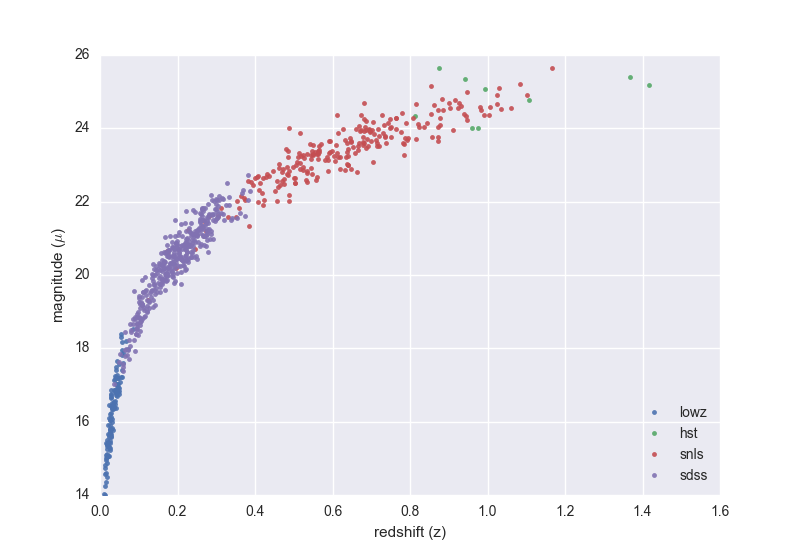

In [15]:
fig, ax = plt.subplots()

for survey in ['lowz','hst','snls','sdss']:

    surCondition = snData['survey'] == survey

    ax.plot(snData[surCondition]['zcmb'],snData[surCondition]['mb'],'.',label=survey,alpha=.9)
    
#ax.set_ylim(bottom=14,top=26)    
ax.legend(loc=4)


ax.set_xlabel('redshift (z)')

ax.set_ylabel(r'magnitude ($\mu$)')

#savefig('/Users/jburgess/Desktop/snsurvey.pdf',bbox_inches='tight')

## Plotting the JLA data

<IPython.core.display.Javascript object>


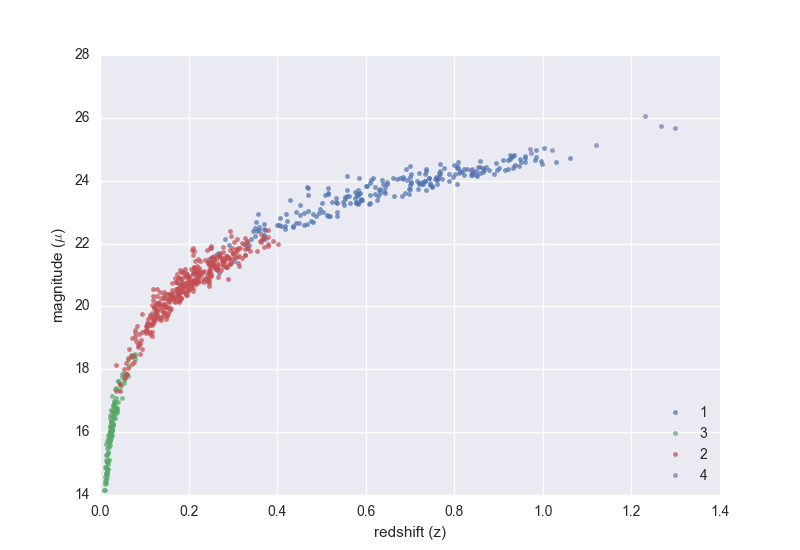

In [16]:
fig, ax = plt.subplots()
for survey in [1,3,2,4]:

    surCondition = jlaSet['set'] == survey

    ax.plot(jlaSet[surCondition]['zcmb'],jlaSet[surCondition]['mb'],'.',label=survey,alpha=.7)
    
#ax.set_ylim(bottom=14,top=26)     
ax.legend(loc=4)

ax.set_xlabel('redshift (z)')

ax.set_ylabel(r'magnitude ($\mu$)')


## Theano Setup

For speed and ease, transform the numpy arrays of data into Theano shared variables.


In [18]:

JZ=theano.shared(snData['zcmb'])

color=theano.shared(snData['color'])

dcolor=theano.shared(snData['dcolor'])

x1=theano.shared(snData['x1'])

dx1=theano.shared(snData['dx1'])

mbObs=theano.shared(snData['mb'])

dmbObs=theano.shared(snData['dmb'])

nSN = len(snData)

## Model Setup

Here we setup the model. This is experimental at the moment. the priors are not optimal and it is a blend of previous models and BAHAMAS.



In [19]:
model= pm.Model()


    
    
with model:    
    
  
    
    
    
    
    # COSMOLOGY
    
    # H0 is set instead of sampled at the moment
    H0 =72.# pm.Normal('H0',mu=72.,sd=8.)
    
    OmegaM = pm.Uniform("OmegaM",lower=0,upper=1.)
    
    # Only needed if we want to sample w
    #w      = pm.Normal("w",mu=-1,sd=1)
    
    
    # My custom distance mod. function to enable 
    # ADVI and HMC smapling.
    
    #dm = distmodW(OmegaM,w,JZ)
    dm = distmod(OmegaM,H0,JZ)
  
    
    
    # PHILIPS PARAMETERS
    
    # M0 is the location parameter for the distribution 
    # sysScat is the scale parameter for the M0 distribution
    # rather than "unexpalined variance"
    M0      = pm.Uniform("M0",lower=-20.,upper=-18.)
    sysScat = pm.HalfCauchy('sysScat',beta=2.5) # Gelman recommendation for variance parameter
    M_true = pm.Normal('M_true',M0,sysScat,shape=nSN)
    
    
    
    # following Rubin's Unity model... best idea? not sure
    taninv_alpha = pm.Uniform("taninv_alpha",lower=-.2,upper=.3)
    taninv_beta = pm.Uniform("taninv_beta",lower=-1.4,upper=1.4)
    
    # Transform variables
    alpha=pm.Deterministic('alpha',T.tan(taninv_alpha))
    beta=pm.Deterministic('beta',T.tan(taninv_beta))
    
  
    # Again using Rubin's Unity model.
    # After discussion with Rubin, the idea is that
    # these parameters are ideally sampled from a Gaussian,
    # but we know they are not entirely correct. So instead, 
    # the Cauchy is less informative around the mean, while 
    # still having informative tails.
    
    xm=pm.Cauchy('xm',alpha=0,beta=1)
    cm=pm.Cauchy('cm',alpha=0,beta=1)
    
    Rx_log=pm.Uniform('Rx_log',lower=-0.5,upper=0.5)
    Rc_log=pm.Uniform('Rc_log',lower=-1.5,upper=1.5)
    
    # Transformed variables
    Rx=pm.Deterministic("Rx",T.pow(10.,Rx_log))
    Rc=pm.Deterministic("Rc",T.pow(10.,Rc_log))


    x_true  = pm.Normal('x_true',mu=xm, sd=Rx,shape=nSN)
    c_true  = pm.Normal('c_true',mu=cm, sd=Rc,shape=nSN)
    
    
   

    # Do the correction 
    mb = pm.Deterministic("mb",M_true + dm - alpha*x_true + beta*c_true)
    
    
    # Likelihood and measurement error
    
    obsc=pm.Normal("obsc",mu=c_true,sd=dcolor, observed=color)
    obsx=pm.Normal("obsx",mu=x_true,sd=dx1, observed=x1)
    obsm = pm.Normal("obsm",mu=mb,sd=dmbObs,observed=mbObs)

Applied interval-transform to OmegaM and added transformed OmegaM_interval_ to model.
Applied interval-transform to M0 and added transformed M0_interval_ to model.
Applied log-transform to sysScat and added transformed sysScat_log_ to model.
Applied interval-transform to taninv_alpha and added transformed taninv_alpha_interval_ to model.
Applied interval-transform to taninv_beta and added transformed taninv_beta_interval_ to model.
Applied interval-transform to Rx_log and added transformed Rx_log_interval_ to model.
Applied interval-transform to Rc_log and added transformed Rc_log_interval_ to model.


## ADVI

First we will sample with ADVI to build the model covarince and get some good starting points

<IPython.core.display.Javascript object>


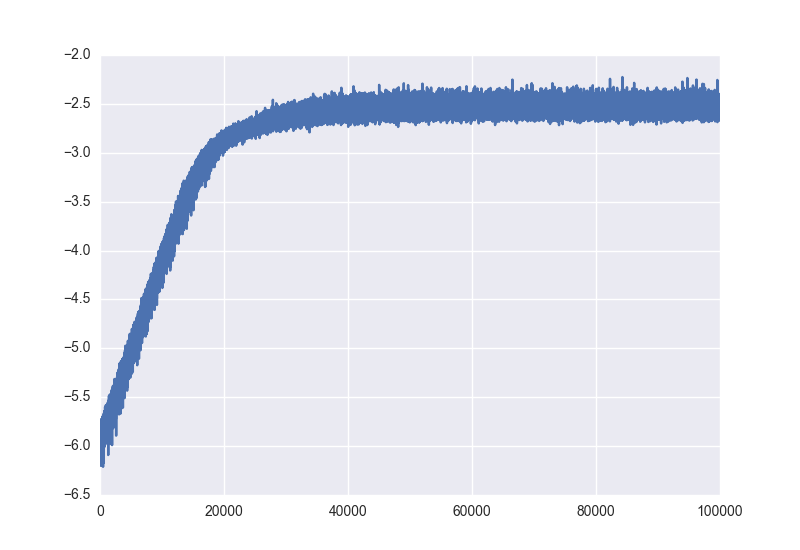

Iteration 0 [0%]: ELBO = -876478.56
Iteration 10000 [10%]: Average ELBO = -202450.67
Iteration 20000 [20%]: Average ELBO = -3292.98
Iteration 30000 [30%]: Average ELBO = -559.78
Iteration 40000 [40%]: Average ELBO = -398.55
Iteration 50000 [50%]: Average ELBO = -362.58
Iteration 60000 [60%]: Average ELBO = -351.32
Iteration 70000 [70%]: Average ELBO = -346.66
Iteration 80000 [80%]: Average ELBO = -344.78
Iteration 90000 [90%]: Average ELBO = -343.29
Finished [100%]: Average ELBO = -342.93


In [20]:
fig, ax = plt.subplots()

with model:
    v_params = pm.variational.advi(n=100000, verbose=True)

    ax.plot(-np.log10(-v_params.elbo_vals))

## Sample with NUTS

Now we will build the posterior. We can use several chains for cross checking. 

In [21]:
with model:
    
    step = pm.NUTS(scaling=np.power(model.dict_to_array(v_params.stds),2), is_cov=True)

    trc_nuts_scale = pm.sample(draws=5000, njobs=3, step=step, start=v_params.means)

100%|██████████| 5000/5000 [07:31<00:00, 11.08it/s]


<IPython.core.display.Javascript object>


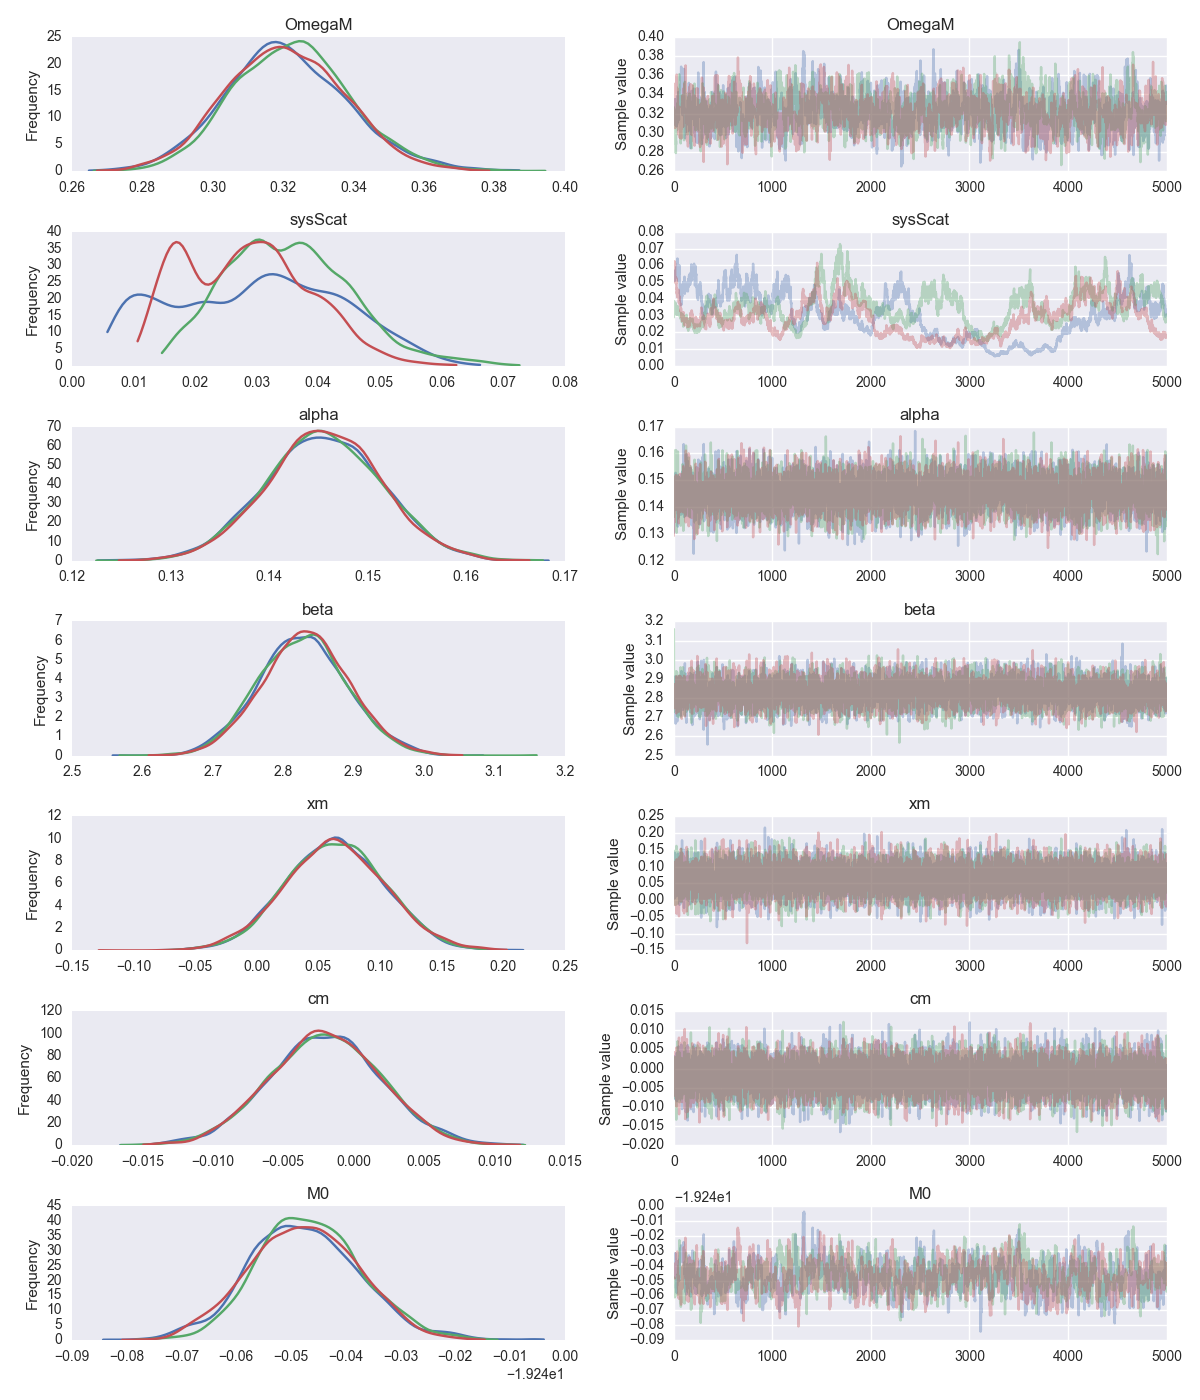

In [30]:
_=pm.traceplot(trc_nuts_scale,varnames=['OmegaM','sysScat','alpha','beta','xm','cm','M0'])

### Gelman-Rubin stats to check for convergence

In [32]:
pm.gelman_rubin(trc_nuts_scale)

{'M0': 1.0022215533895773,
 'M0_interval_': 1.0022387217543873,
 'M_true': array([ 1.00025541,  1.00201441,  1.00149806,  1.00051193,  1.00034562,
         1.00022746,  1.0020578 ,  1.00003261,  1.00071373,  1.0019808 ,
         1.00063883,  1.00245661,  1.00413189,  1.00278807,  1.00009281,
         1.0021849 ,  1.0025889 ,  1.00034037,  1.00124231,  1.00021851,
         0.99998684,  1.00029426,  1.0000344 ,  1.00075782,  0.99992466,
         1.00006448,  1.00184835,  1.00008746,  0.99992296,  1.00207921,
         1.00007242,  1.00164369,  1.00065923,  1.00017869,  1.00009075,
         0.99993146,  1.00101733,  1.00244299,  1.00053213,  1.00042311,
         1.00018877,  0.99990467,  1.00000551,  0.99991955,  1.00128407,
         1.00869103,  1.00170682,  1.00012877,  1.00381895,  1.00013632,
         1.00181587,  0.99990797,  1.00367371,  0.99992075,  0.99994339,
         1.00100454,  1.00001316,  1.00111056,  1.00090912,  1.00005807,
         1.00085781,  1.00022189,  1.00078371,  1.

### Check that we get the correct latent M distribution

It looks like at the moment we are not getting the scale right. This is probably due to my simulations
not beign done correctly.

<IPython.core.display.Javascript object>


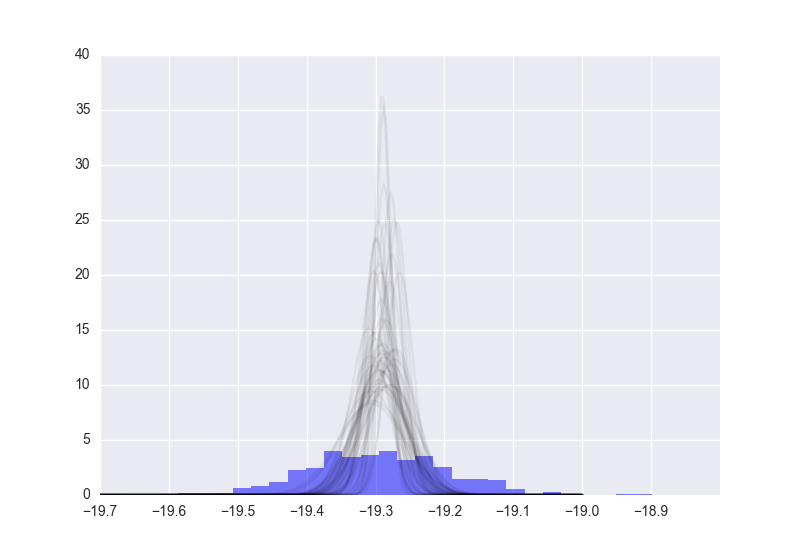

In [28]:
import scipy.stats as stats

burnin=100
thin=100
fig, ax =  plt.subplots()

# Define a properly normalized Gaussian so that we can compare 
# histograms to distributions

def pmNorm(x,mu,sd):
    
    return np.sqrt(1./(sd**2*np.pi*2))*np.exp(-(x-mu)**2 /(2*(sd**2)) )




x_plot = np.linspace(-19.7, -19, 200)

for tr in trc_nuts_scale[burnin::thin]:

     ax.plot(x_plot,pmNorm(x_plot, tr['M0'], tr['sysScat']),c='k',alpha=.05)


ax.hist(snTruth['M'], bins=30, normed=True,
        color='b', lw=0, alpha=0.5);


### Plot the SNe Cosmology curve to check

<IPython.core.display.Javascript object>


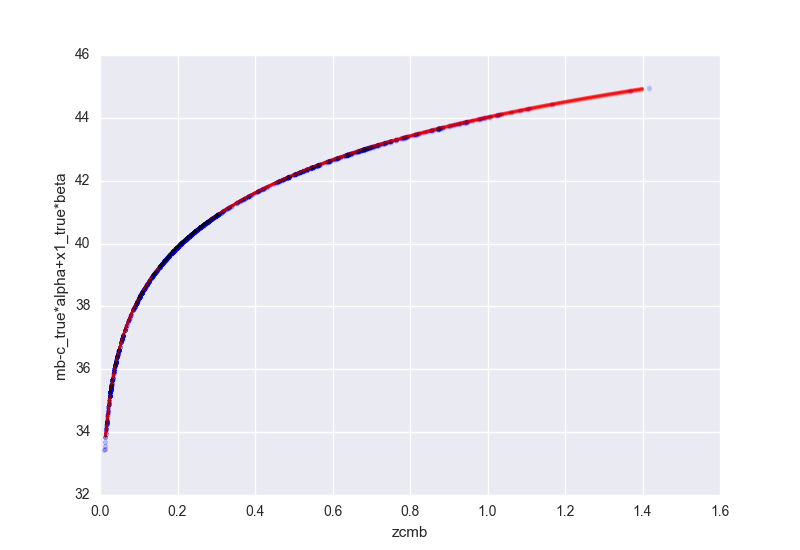

In [38]:
import astropy.cosmology as cosmology
fig, ax =  plt.subplots()


zGrid = np.linspace(0,1.4,100)

for tr in trc_nuts_scale[burnin::thin]:
    
    spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=tr['OmegaM'])
    ax.plot(zGrid,spefCosmo.distmod(zGrid).value,'r',alpha=0.05)
    ax.plot(snData['zcmb'],tr['mb']-tr['M_true']-tr['c_true']*tr['beta']+tr['alpha']*tr['x_true'],'b.',alpha=0.005)
    
    
ax.set_xlabel("zcmb")
ax.set_ylabel("mb-c_true*alpha+x1_true*beta")

## Plot the parameters

Here we plot the good ole marginals. Notice that at the moment things are not lining up with the simulations. This is again due to the poor simulations that I am doing. 


First I need to rearrange the data into something useful!

In [81]:
# Make a pandas dataframe so I can manipulate names
# and add on paramaters

df_trace = pm.trace_to_dataframe(trc_nuts_scale[burnin:])
df_trace.rename(columns={'alpha':r'$\alpha$','beta':r'$\beta$','OmegaM':r'$\Omega_M$'},inplace=True)

# add the dark energy
OL = 1-df_trace['$\Omega_M$']
df_trace['$\Omega_\Lambda$'] = OL

# Now pandas makes crappy dictionaries for chain consumer,
# so make ones that work
proper_dict = {}
improper_dict = df_trace.to_dict()


for key in improper_dict.keys():
    
    proper_dict[key] =   np.array([ improper_dict[key][i] for i in  range(len(improper_dict[key]))  ] )
    



chain_builder = ChainConsumer()
chain_builder.add_chain(proper_dict)


<IPython.core.display.Javascript object>


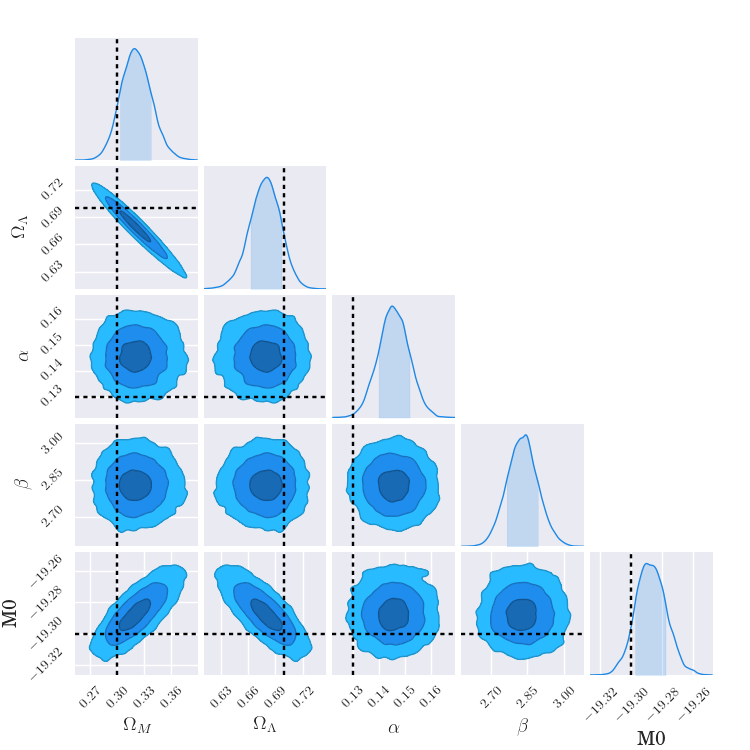

In [102]:
_=chain_builder.plot(parameters=['$\Omega_M$','$\Omega_\Lambda$',r'$\alpha$',r'$\beta$','M0'],truth=[.3,.7,0.13,2.56,-19.3])